# **Medical Diagnosis with Bayesian Network**

In [478]:
!pip install pyagrum pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [479]:
import os
import numpy as np
import pandas as pd
from pylab import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC
from collections import Counter
from IPython.core.display import display, HTML
import time
import logging

In [480]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [481]:
#Formatting 
pd.set_option('display.max_columns', None)

path = '/content/drive/MyDrive/ColabNotebooks/Data/7-dataset.csv'

display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [482]:
#Basic
def get_jpd_size(bn):
    return np.prod([bn.variable(node).domainSize() for node in bn.nodes()])

def get_cpts_size(bn):
    return sum([np.prod(bn.cpt(node).var_dims) for node in bn.nodes() ])  

def compression_ratio(bn):
    return 100*(1-get_cpts_size(bn)/ get_jpd_size(bn))

def post(row,bn,target):
        ie = gum.LazyPropagation(bn)
        evs = row.astype(str).to_dict()
        #print(evs)
        del evs[target]
        ie.setEvidence(evs)
        ie.addTarget(target)
        return ie.posterior(target).toarray()[1]

In [483]:
class BNEstimator(BaseEstimator, ClassifierMixin):
    """
    csv_template is used to create the modalities for the BN"""
    def __init__(self,
                 csv_template=None,
                 bn=None,
               mandatory_arcs=[],
               tabu_arcs=[],
               class_name = None,
               learning_method='greedy',
               prior='likelihood', 
               prior_weight=.5, 
               positif_label = None,
               threshold = .5,
               nb_classes = 2,               
               cut_points_percentiles  = list(100*np.linspace(0, 1,5)),
               bins=5):
        
        
        self.csv_template = csv_template
        self.mandatory_arcs = mandatory_arcs
        self.tabu_arcs = tabu_arcs
        self.class_name = class_name
        self.learning_method = learning_method
        self.prior = prior
        self.prior_weight = prior_weight
        self.positif_label = positif_label
        self.threshold = threshold
        self.nb_classes = nb_classes
        self.cut_points_percentiles = cut_points_percentiles
        self.bins = bins
        self.bn = bn
    def get_params(self, deep=True):
        return {"csv_template":self.csv_template,# template for modalities
            "class_name":self.class_name,
            "mandatory_arcs": self.mandatory_arcs,
                "tabu_arcs":self.tabu_arcs,
                "learning_method": self.learning_method, 
               "prior": self.prior,
               "prior_weight":  self.prior_weight,
              "class_name"  :self.class_name ,
              "positif_label"  :self.positif_label ,
              "threshold" : self.threshold ,
              "nb_classes"  :self.nb_classes ,
              "cut_points_percentiles"  :self.cut_points_percentiles,
            "bins" : self.bins}

    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def transform(self,d):
        """Transfrom the whole dataset before training
        param d : dataframe 
        """
        template = gum.BayesNet()
        numeric_cols = list(d.select_dtypes(include=[np.number]).columns)
        categorical_cols = list(d.select_dtypes(include=[object]).columns)

        
        for col in numeric_cols:
            if d[col].value_counts().shape[0]>self.bins:
                x = d[col].values.flatten()
                x.sort()
                cut_points = np.percentile(x, self.cut_points_percentiles)
                d.loc[:,col]= np.digitize(x, cut_points, right=False)   
                del x
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index)))) 
        for col in categorical_cols:
            if d[col].value_counts().shape[0]>self.bins:
                top = d[col].isin(d[col].value_counts().index[:self.bins])
                d.loc[~top, col] = "else_top_"+str(self.bins)

                del top
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index))))
        return template,d

    def fit(self,data,y=None):
        """Create the template and Fit the training dataset: data_file"""
        
        # create the template   
        template,_ = self.transform(pd.read_csv(self.csv_template))
        _,train= self.transform(data)
                
            
        train.to_csv('train_bn.csv',index=False)
        learner = gum.BNLearner('train_bn.csv', template)

        
        for i in self.tabu_arcs: learner.addForbiddenArc(i[0],i[1])
        for i in self.mandatory_arcs :  learner.addMandatoryArc(i[0],i[1])

        if self.learning_method == 'greedy':learner.useGreedyHillClimbing()
        else: learner.useMIIC()

        if self.prior == "laplace":learner.useAprioriSmoothing(self.prior_weight)
        else:learner.useNoApriori()
            
        
        self.bn = learner.learnBN()
        self.bn = learner.learnParameters(self.bn.dag())        
        del template,train

        return self

    def predict_one_row(self,row):
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name) 
        
        evs = row.astype(str).to_dict()
        del evs[self.class_name]      
        ie.setEvidence(evs)
        ie.makeInference()
        return ie.posterior(self.class_name).toarray()
    
    def predict_proba1(self,test):#,mb=True):
        scores = np.empty([test.shape[0], self.nb_classes])
        scores[:] = np.nan
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name) 
        
        for i in range(len(test)):    
            evs = test.iloc[i,:].astype(str).to_dict()
            del evs[self.class_name]               
            ie.setEvidence(evs)
            ie.makeInference()
            scores[i] = ie.posterior(self.class_name).toarray()
        return scores
    
    def predict_proba(self, Xtest):
        if type(Xtest) is np.ndarray:
            Xtest = pd.DataFrame(Xtest, columns=["X{}".format(i) for i in range(Xtest.shape[1])])

        Yscores = np.empty([Xtest.shape[0], self.nb_classes])
        Yscores[:] = np.nan

        mbnames = [self.bn.variable(i).name()
                   for i in gum.MarkovBlanket(self.bn, self.class_name).nodes()
                   if self.bn.variable(i).name() != self.class_name]
        ie = gum.LazyPropagation(self.bn)
        for var in ie.BN().names():  
            if var != self.class_name:
                ie.addEvidence(var, 0)
        ie.addTarget(self.class_name)

        Xtest = Xtest.reset_index(drop=True)

        for line in Xtest.itertuples():
            for var in mbnames:
                try:
                    idx = self.bn.variable(var).index(str(getattr(line, var)))
                    ie.chgEvidence(var, idx)
                except gum.GumException:
                # this can happen when value is missing is the test base.
                    print("[pyAgrum] ** pyAgrum.lib.classifier : The value {getattr(line, var)} for the variable {var} is missing in the training set.")
                    pass

            ie.makeInference()

            marginal = ie.posterior(self.class_name)
            Yscores[line[0]] = marginal.toarray()

        return Yscores
    
    def predict(self,test):
        y_scores = self.predict_proba(test)[:,1]
        y_true = test[self.class_name]
        
        return y_true, np.where(y_scores >= self.threshold, 1, 0)
    
 
    def score(self,test):
        from sklearn.metrics import recall_score, f1_score, classification_report
        y_true,y_pred = self.predict(test)
        print(classification_report(y_true, y_pred))
        print(5*'--')
        print('recall_score')
        return recall_score(y_true, y_pred)

In [484]:
df_heart = pd.read_csv(path)

print(df_heart.shape)
df_heart.head()

(303, 14)


,age,gender,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heartdisease
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [516]:
means = dict()
num = 0

for i in df_heart.columns:
  if df_heart.iloc[:,num].dtype == (float) or df_heart.iloc[:,num].dtype == (int):
    means[i] = df_heart[i].mean()
    df_heart[i].fillna(means[i], inplace=True) 
    for j in range(0,df_heart.shape[0]):
      if df_heart.iloc[j,num] == '?':
        df_heart.iloc[j,num] = means[i]
    num = num+1
means

{'age': 54.43894389438944,
 'gender': 0.6798679867986799,
 'cp': 3.1584158415841586,
 'trestbps': 131.68976897689768,
 'chol': 246.69306930693068,
 'fbs': 0.1485148514851485,
 'restecg': 0.9900990099009901,
 'thalach': 149.6072607260726,
 'exang': 0.32673267326732675,
 'oldpeak': 1.0396039603960396,
 'slope': 1.6006600660066006}

In [486]:
df_heart.isnull().sum()

age             0
gender          0
cp              0
trestbps        0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
thal            0
heartdisease    0
dtype: int64

In [487]:
df_heart.nunique()

age              41
gender            2
cp                4
trestbps         50
chol            152
fbs               2
restecg           3
thalach          91
exang             2
oldpeak          40
slope             3
ca                5
thal              4
heartdisease      5
dtype: int64

In [488]:
df_heart_copy = df_heart.copy()

In [489]:
#Initialising the BN
df_heart_copy.to_csv(path + 'template.csv', index = False)

clf = BNEstimator(csv_template=path+'template.csv', class_name='heart_disease',
                  cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df_heart_copy)

In [490]:
#Train, test splitting
train,test = train_test_split(data ,test_size=0.3, random_state=0)
train.to_csv(path +'train.csv',index=False)

clf.fit(train)

BNEstimator(class_name='heart_disease',
            csv_template='/content/drive/MyDrive/ColabNotebooks/Data/7-dataset.csvtemplate.csv',
            cut_points_percentiles=[5, 50, 95])

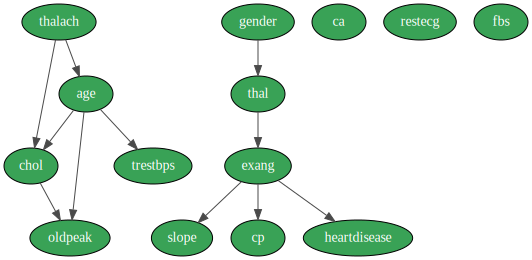

In [491]:
gnb.showBN(clf.bn,size=12,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Greens'))

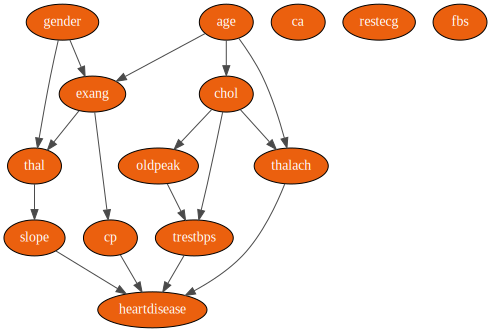

In [492]:
df_heart_copy.to_csv(path + 'template.csv', index = False)

clf = BNEstimator(csv_template=path+'template.csv', class_name='heart_disease',
                  tabu_arcs=[('exang', 'heartdisease'), ('heartdisease', 'chol'),('age', 'oldpeak'), ('age', 'oldpeak'), ('age', 'trestbps'), ('thalach', 'chol'),('oldpeak', 'age'), ('chol', 'age'), ('heartdisease', 'ca'), ('heartdisease', 'restecg'),('thal', 'heartdisease')],
                  mandatory_arcs=[('thalach','heartdisease'),('exang','heartdisease'),('cp','heartdisease'),('heartdisease','restecg'),('heartdisease','chol'), ('age', 'exang'), ('thal','heartdisease'),('gender','exang'),('slope','heartdisease'), ('trestbps','heartdisease'),('thal','slope')],
                  cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df_heart_copy)
train,test = train_test_split(data ,test_size=0.2, random_state=0)
train.to_csv(path +'train.csv',index=False)
test.to_csv(path +'test.csv',index=False)

clf.fit(train)

gnb.showBN(clf.bn,size=8,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Oranges'))

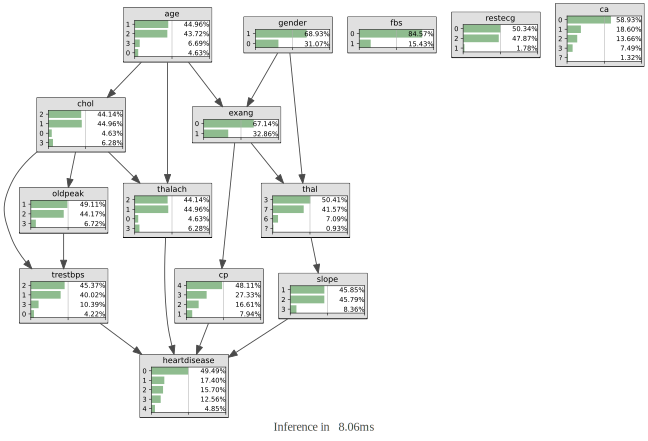

In [493]:
gnb.showInference(clf.bn,size=9)

In [494]:
MB = gum.MarkovBlanket(clf.bn,'heartdisease')
MB

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7ff1593e04e0> >

In [495]:
df_heart.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heartdisease
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


** pyAgrum** For better visualizations, please install matplotlib-inline.


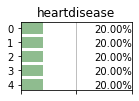

In [511]:
from  random import choice
id = choice(list(clf.bn.nodes().difference(MB.nodes())))
gnb.showPosterior(clf.bn,                             
                  evs={'age': '1',
                       'cp': '1',
                       'trestbps': '1',
                       'chol': '1',
                       'fbs': '1',
                       'exang': '1',
                       'slope': '1',
                       'ca': '1',
                       'thal': '7',
                       'gender': '0',
                       'restecg': '1',
                       'thalach': '3',
                       'oldpeak': '3',
                      clf.bn.variable(id).name():1}, 
                  target= 'heartdisease')

En este caso el algoritmo no pudo determinar si la persona era propensa o no a sufrir de una enfermedad del corazon.

** pyAgrum** For better visualizations, please install matplotlib-inline.


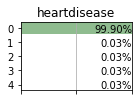

In [512]:
id = choice(list(clf.bn.nodes().difference(MB.nodes())))
gnb.showPosterior(clf.bn,                             
                  evs={'age': '1',
                       'cp': '1',
                       'trestbps': '1',
                       'chol': '1',
                       'fbs': '1',
                       'exang': '1',
                       'slope': '1',
                       'ca': '1',
                       'thal': '7',
                       'gender': '0',
                       'restecg': '1',
                       'thalach': '1',
                       'oldpeak': '1',
                      clf.bn.variable(id).name():1}, 
                  target= 'heartdisease')

Con este otro caso el algoritmo esta seguro con un 99.9% de exactitud que el paciente no padece de ningun problema cardiaco.